# **5. Extention: NLP Models**
We can enhance our analysis of the dataset by leveraging NLP models, starting with a baseline BERT approach to capture deep contextual information from the text. Once we have established this foundation, we can further improve performance by integrating a BiGRU layer on top of the BERT embeddings, enabling the model to capture additional sequence-level dependencies and better handle long-range contextual relationships. This two-step approach—beginning with BERT and then transitioning to a combined BERT+BiGRU model—provides a robust framework for accurately classifying news articles as true or fake.

## 5.1 Bert Model for Text

In [ ]:
fake_news['label'] = 0
true_news['label'] = 1
combined_news = pd.concat([fake_news, true_news], ignore_index=True)
print(combined_news.info())
print(combined_news.head())
X = combined_news['text']  # Use the 'text' column for the text data
Y = combined_news['label']  # Use the 'label' column for the labels

print(X.head())
print(Y.head())

from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  44898 non-null  object 
 1   text                   44898 non-null  object 
 2   subject                44898 non-null  object 
 3   date                   33285 non-null  object 
 4   label                  44898 non-null  int64  
 5   title_processed        44898 non-null  object 
 6   text_processed         44898 non-null  object 
 7   title_cluster          44898 non-null  int32  
 8   text_cluster           44898 non-null  int32  
 9   sentiment_score_text   44898 non-null  float64
 10  word_count_text        44898 non-null  float64
 11  sentence_count_text    44898 non-null  float64
 12  avg_word_length_text   44266 non-null  float64
 13  sentiment_score_title  44898 non-null  float64
 14  word_count_title       44898 non-null  float64
 15  se

In [ ]:
!pip install transformers

from transformers import BertTokenizer

# Create a tokenizer instance
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(X):

    X = bert_tokenizer( # Now using the bert_tokenizer instance
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
X_train = tokenize(X_train)
X_test = tokenize(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from transformers import TFBertModel

# Load a pre-trained BERT model from Hugging Face
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Custom layer to wrap the BERT model
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        # Expecting inputs to be a dictionary with 'input_ids' and 'attention_mask'
        # Returns the pooled output (typically the representation for [CLS])
        return self.bert(inputs)[1]

# Build your custom model for binary classification
def create_model(bert_model, maxlen=100):
    # Define inputs for token ids and attention masks
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # Get the pooled output from the BERT layer
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Add a couple of dropout and dense layers for fine-tuning
    x = Dropout(0.5)(pooled_output)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    # Create the Keras model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model and compile it
model = create_model(bert_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 768)            │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         49,216 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Initialize the Adam optimizer with specified parameters
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)

# Compile the model using binary crossentropy and accuracy as the metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to halt training when validation loss does not improve for 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [ ]:
history = model.fit(
    x={
        'input_ids': X_train['input_ids'],
        'attention_mask': X_train['attention_mask']
    },
    y=y_train,
    epochs=20,
    batch_size=30,
    validation_data=(
        {
            'input_ids': X_test['input_ids'],
            'attention_mask': X_test['attention_mask']
        },
        y_test
    ),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 60s 33ms/step - accuracy: 0.5143 - loss: 0.8088 - val_accuracy: 0.6957 - val_loss: 0.6360 - learning_rate: 1.0000e-05
Epoch 2/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5600 - loss: 0.7434 - val_accuracy: 0.7986 - val_loss: 0.5742 - learning_rate: 1.0000e-05
Epoch 3/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6042 - loss: 0.6821 - val_accuracy: 0.8233 - val_loss: 0.5218 - learning_rate: 1.0000e-05
Epoch 4/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6347 - loss: 0.6428 - val_accuracy: 0.8454 - val_loss: 0.4787 - learning_rate: 1.0000e-05
Epoch 5/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6739 - loss: 0.6036 - val_accuracy: 0.8497 - val_loss: 0.4466 - learning_rate: 1.0000e-05
Epoch 6/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7047 - loss: 0.5713 - val_accuracy: 0.8548 - val_loss: 0.4213 - learning_rate: 1.0000e-05
Epoch 7/20
1198/1198 ━━━━━━━━━━━━━━━━━━━

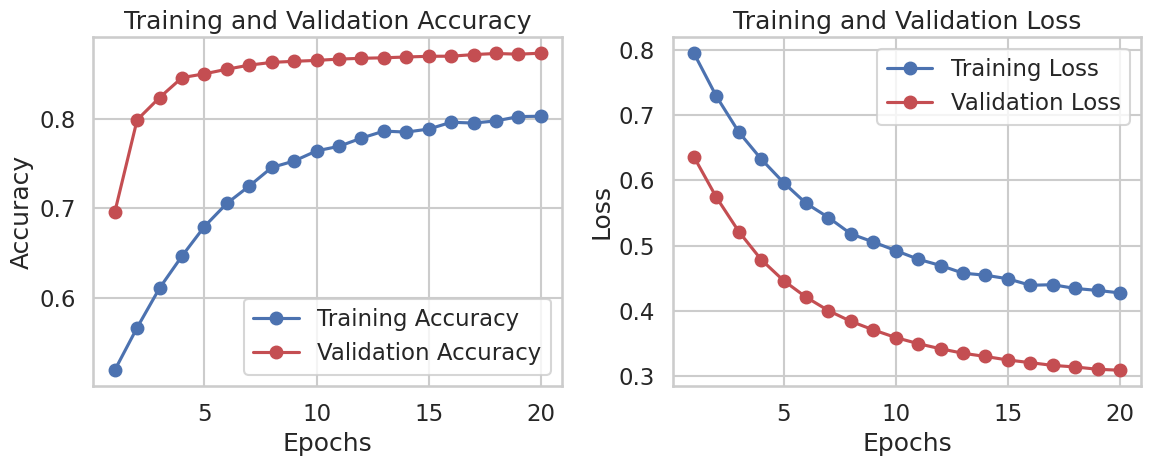

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Create a figure with two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step
Confusion Matrix:
[[4264  469]
 [ 673 3574]]


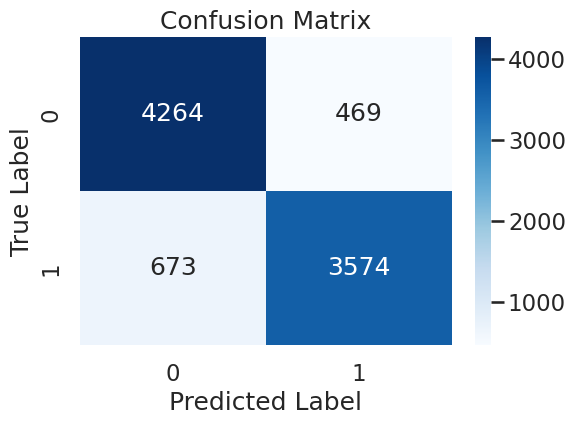


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4733
           1       0.88      0.84      0.86      4247

    accuracy                           0.87      8980
   macro avg       0.87      0.87      0.87      8980
weighted avg       0.87      0.87      0.87      8980

Accuracy: 0.87
Precision: 0.88
Recall: 0.84
F1-Score: 0.86


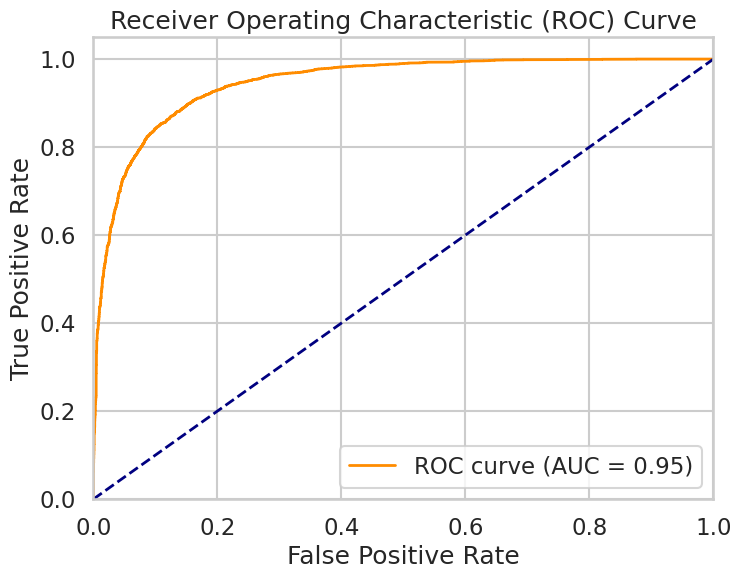

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, auc, confusion_matrix,
                             classification_report, accuracy_score,
                             precision_score, recall_score, f1_score)

# Generate predicted probabilities on the test set
y_pred_probs = model.predict({
    'input_ids': X_test['input_ids'],
    'attention_mask': X_test['attention_mask']
}).flatten()

# Convert predicted probabilities to binary labels using a 0.5 threshold
y_pred_labels = (y_pred_probs > 0.5).astype("int32")

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 2. Classification Report (Precision, Recall, F1-Score, Support)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))

# 3. Additional Metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

# 4. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




## 5.2 Bert + Bidirectional-GRU Model For Text

In [ ]:
fake_news['label'] = 0
true_news['label'] = 1
combined_news = pd.concat([fake_news, true_news], ignore_index=True)
print(combined_news.info())
print(combined_news.head())
X = combined_news['text']  # Use the 'text' column for the text data
Y = combined_news['label']  # Use the 'label' column for the labels

print(X.head())
print(Y.head())

from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  44898 non-null  object 
 1   text                   44898 non-null  object 
 2   subject                44898 non-null  object 
 3   date                   33285 non-null  object 
 4   label                  44898 non-null  int64  
 5   title_processed        44898 non-null  object 
 6   text_processed         44898 non-null  object 
 7   title_cluster          44898 non-null  int32  
 8   text_cluster           44898 non-null  int32  
 9   sentiment_score_text   44898 non-null  float64
 10  word_count_text        44898 non-null  float64
 11  sentence_count_text    44898 non-null  float64
 12  avg_word_length_text   44266 non-null  float64
 13  sentiment_score_title  44898 non-null  float64
 14  word_count_title       44898 non-null  float64
 15  se

In [ ]:
!pip install transformers

from transformers import BertTokenizer

# Create a tokenizer instance
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(X):

    X = bert_tokenizer( # Now using the bert_tokenizer instance
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [ ]:
X_train = tokenize(X_train)
X_test = tokenize(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, GRU, Lambda
from tensorflow.keras.models import Model
from transformers import TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score)

# Load pre-trained BERT model (TF 2.0)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.trainable = True  # Allow fine-tuning

# Get the hidden size from the model configuration
hidden_dim = bert_model.config.hidden_size  # typically 768 for bert-base-uncased

def create_model_with_gru(bert_model, maxlen=100):
    # Define input layers
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # Prepare inputs as a dictionary
    bert_inputs = {"input_ids": input_ids, "attention_mask": attention_mask}

    # Wrap the BERT call in a Lambda layer to force proper tensor conversion.
    # We return the last_hidden_state which has shape: (batch_size, maxlen, hidden_dim)
    bert_outputs = Lambda(
        lambda inputs: bert_model(**inputs).last_hidden_state,
        output_shape=(maxlen, hidden_dim)
    )(bert_inputs)

    # Pass the BERT sequence output through a Bidirectional GRU layer
    x = Bidirectional(GRU(64, return_sequences=False))(bert_outputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Build and compile the model
model_gru = create_model_with_gru(bert_model, maxlen=100)
model_gru.compile(optimizer=Adam(learning_rate=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Display model summary
model_gru.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 100, 768)       │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │        320,256 │ lambda[0][0]           │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 328,577 (1.25 MB)

 Trainable params: 328,577 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

history = model_gru.fit(
    x={
        'input_ids': X_train['input_ids'],
        'attention_mask': X_train['attention_mask']
    },
    y=y_train,
    epochs=20,
    batch_size=30,
    validation_data=(
        {
            'input_ids': X_test['input_ids'],
            'attention_mask': X_test['attention_mask']
        },
        y_test
    ),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 79s 53ms/step - accuracy: 0.7127 - loss: 0.5420 - val_accuracy: 0.9829 - val_loss: 0.0755 - learning_rate: 2.0000e-05
Epoch 2/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9793 - loss: 0.0820 - val_accuracy: 0.9903 - val_loss: 0.0327 - learning_rate: 2.0000e-05
Epoch 3/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9903 - loss: 0.0370 - val_accuracy: 0.9933 - val_loss: 0.0214 - learning_rate: 2.0000e-05
Epoch 4/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9931 - loss: 0.0244 - val_accuracy: 0.9945 - val_loss: 0.0163 - learning_rate: 2.0000e-05
Epoch 5/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9948 - loss: 0.0185 - val_accuracy: 0.9955 - val_loss: 0.0129 - learning_rate: 2.0000e-05
Epoch 6/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 60s 50ms/step - accuracy: 0.9972 - loss: 0.0128 - val_accuracy: 0.9965 - val_loss: 0.0109 - learning_rate: 2.0000e-05
Epoch 7/20
1198/1198 ━━━━━━━━━━━━━━━━━━━

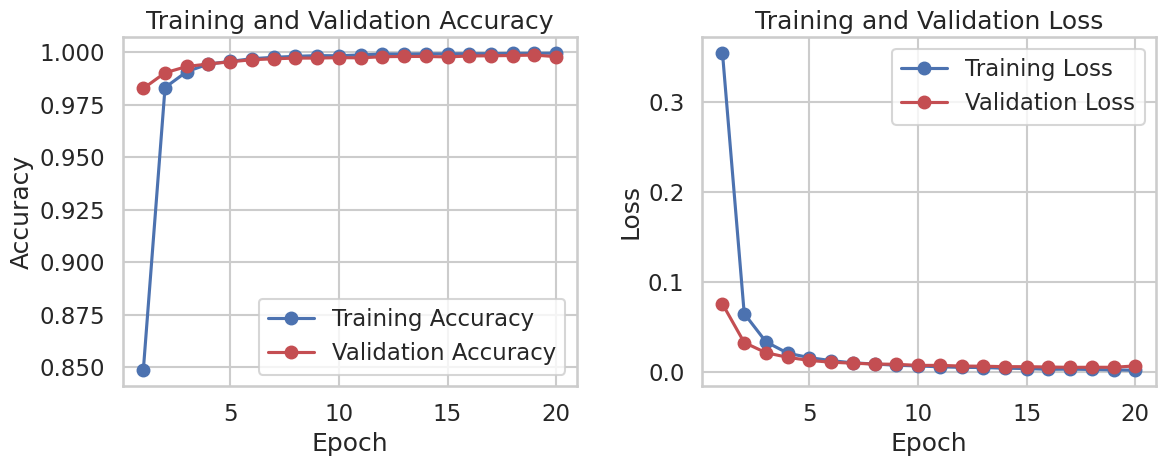

281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Confusion Matrix:
[[4727    6]
 [   8 4239]]


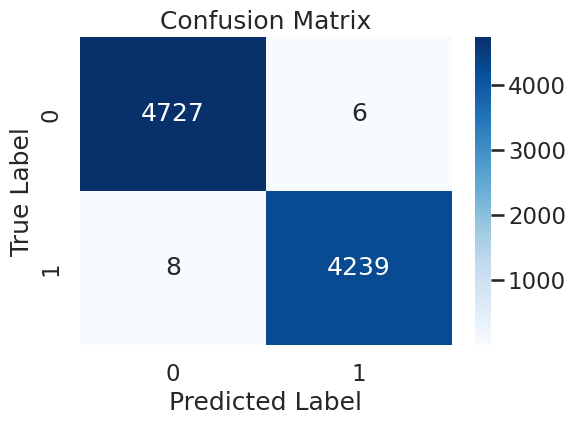

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4733
           1       1.00      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


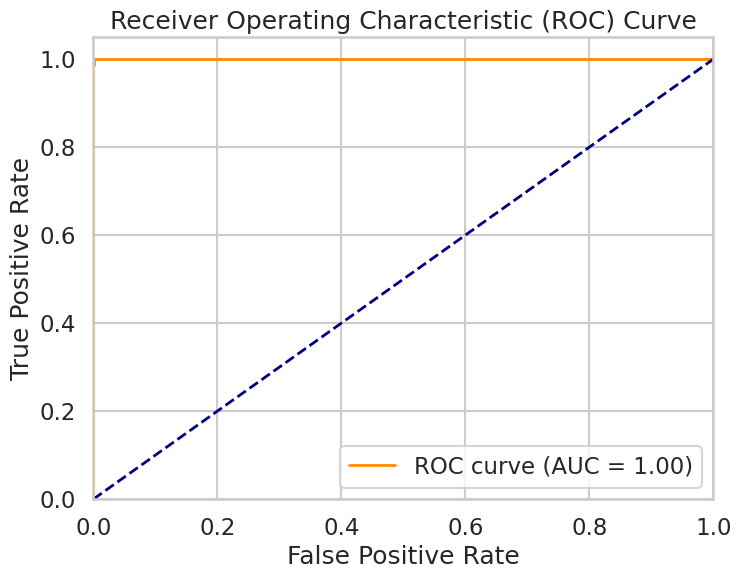

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score)

# Plot training & validation accuracy and loss
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate the model: get predictions on the test set
y_pred_probs = model_gru.predict({
    'input_ids': X_test['input_ids'],
    'attention_mask': X_test['attention_mask']
}).flatten()

y_pred_labels = (y_pred_probs > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Additional Metrics
acc = accuracy_score(y_test, y_pred_labels)
prec = precision_score(y_test, y_pred_labels)
rec = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)
print("Accuracy: {:.2f}".format(acc))
print("Precision: {:.2f}".format(prec))
print("Recall: {:.2f}".format(rec))
print("F1 Score: {:.2f}".format(f1))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Shap

In [ ]:
!pip install shap
import shap
import numpy as np


In [ ]:
def leave_one_token_out(model, tokenizer, input_ids, attention_mask, class_idx=0):
    """
    model: Your trained Keras model (e.g., BERT + GRU classification head).
    tokenizer: The BertTokenizer (so we can find mask_token_id).
    input_ids, attention_mask: Arrays for one sample, shape (max_len,).
    class_idx: Which output index to compare if multi-class. For binary classification with a single sigmoid, it's 0.

    Returns:
        token_importances: a list of importance values for each token.
    """
    import numpy as np

    # 1) Baseline prediction
    baseline_pred = model.predict({
        'input_ids': input_ids[np.newaxis, :],
        'attention_mask': attention_mask[np.newaxis, :]
    })[0][0]  # shape might be (1,1) => pick the first element

    token_importances = []
    max_len = input_ids.shape[0]

    # 2) Iterate over each token position
    for i in range(max_len):
        # Make a copy of input_ids
        temp_ids = input_ids.copy()

        # Replace this token with [MASK]
        # You could also use the pad token or some other special token
        temp_ids[i] = tokenizer.mask_token_id

        # 3) Re-run prediction
        pred_modified = model.predict({
            'input_ids': temp_ids[np.newaxis, :],
            'attention_mask': attention_mask[np.newaxis, :]
        })[0][0]

        # 4) Importance = absolute change in predicted probability
        importance = abs(baseline_pred - pred_modified)
        token_importances.append(importance)

    return token_importances

# Example usage:
# Pick a single sample from your test set (say index 0)
sample_ids = X_test['input_ids'][0].numpy()         # shape: (max_len,)
sample_mask = X_test['attention_mask'][0].numpy()   # shape: (max_len,)

importances = leave_one_token_out(
    model=model_gru,
    tokenizer=bert_tokenizer,
    input_ids=sample_ids,
    attention_mask=sample_mask
)

# Convert token IDs back to actual tokens
tokens = bert_tokenizer.convert_ids_to_tokens(sample_ids)

for tok, imp in zip(tokens, importances):
    print(f"{tok}: {imp:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

Subject importance

In [ ]:
import pandas as pd

# Example subjects
subjects_dummies = pd.get_dummies(combined_news['subject'], prefix='subject')
# This yields columns like subject_Politics, subject_US-News, etc.
# Each row is 0 or 1 in exactly one column (assuming single-label subjects).

# Combine these new columns back into your DataFrame or keep them separate
combined_news = pd.concat([combined_news, subjects_dummies], axis=1)



In [ ]:
# Suppose subject_cols is a list of the new columns
subject_cols = [col for col in combined_news.columns if col.startswith('subject_')]
# For instance: ['subject_Politics', 'subject_US-News', 'subject_Worldnews', ...]

# Build the numeric array
X_subject = combined_news[subject_cols].values  # shape: (num_samples, num_subjects)


In [ ]:
from sklearn.model_selection import train_test_split

X_text = combined_news["text_processed"]  # or however you get your text
y = combined_news["label"]                # 0/1 for fake vs real

X_train_text, X_test_text, X_train_sub, X_test_sub, y_train, y_test = train_test_split(
    X_text,
    X_subject,
    y,
    test_size=0.2,
    random_state=42
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Bidirectional, GRU, Lambda
from tensorflow.keras.models import Model
from transformers import TFBertModel

def create_model_with_subject(bert_model, num_subjects, maxlen=100):
    # 1) BERT text inputs
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # 2) Subject input
    subject_input = Input(shape=(num_subjects,), dtype=tf.float32, name="subject_input")

    # 3) BERT call via a Lambda layer
    bert_outputs = Lambda(
        lambda inputs: bert_model(**inputs).last_hidden_state,
        output_shape=(maxlen, bert_model.config.hidden_size)
    )({"input_ids": input_ids, "attention_mask": attention_mask})

    # 4) GRU on BERT's sequence output
    x = Bidirectional(GRU(64, return_sequences=False))(bert_outputs)
    x = Dropout(0.5)(x)

    # 5) Concatenate subject features
    merged = Concatenate()([x, subject_input])

    # 6) Classification head
    merged = Dense(64, activation="tanh")(merged)
    merged = Dropout(0.5)(merged)
    output = Dense(1, activation="sigmoid")(merged)

    model = Model(inputs=[input_ids, attention_mask, subject_input], outputs=output)
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


In [ ]:
!pip install transformers
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Or any other BERT variant you prefer

train_encodings = tokenizer(X_train_text.tolist(), truncation=True, padding='max_length', max_length=100) # Make sure X_train_text is a list
X_train_ids = np.array(train_encodings['input_ids'])
X_train_mask = np.array(train_encodings['attention_mask'])
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.trainable = True
test_encodings = tokenizer(
    X_test_text.tolist(),  # Convert test Series to a list
    truncation=True,
    padding='max_length',
    max_length=100
)

# 2) Convert to NumPy arrays
X_test_ids = np.array(test_encodings['input_ids'])
X_test_mask = np.array(test_encodings['attention_mask'])
num_subjects = len(subject_cols)  # e.g. 5
model = create_model_with_subject(bert_model, num_subjects, maxlen=100)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Train
history = model.fit(
    x={
        'input_ids': X_train_ids,          # shape (train_samples, 100)
        'attention_mask': X_train_mask,    # shape (train_samples, 100)
        'subject_input': X_train_sub       # shape (train_samples, num_subjects)
    },
    y=y_train,
    validation_data=(
        {
            'input_ids': X_test_ids,
            'attention_mask': X_test_mask,
            'subject_input': X_test_sub
        },
        y_test
    ),
    epochs=3,
    batch_size=32
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 74s 54ms/step - accuracy: 0.7475 - loss: 0.5015 - val_accuracy: 0.9849 - val_loss: 0.0690
Epoch 2/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - accuracy: 0.9837 - loss: 0.0738 - val_accuracy: 0.9916 - val_loss: 0.0292
Epoch 3/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - accuracy: 0.9915 - loss: 0.0331 - val_accuracy: 0.9943 - val_loss: 0.0190


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

y_pred_probs = model.predict({
    'input_ids': X_test_ids,
    'attention_mask': X_test_mask,
    'subject_input': X_test_sub
}).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

baseline_acc = accuracy_score(y_test, y_pred)
print("Baseline accuracy:", baseline_acc)


281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step
Baseline accuracy: 0.9943207126948775


In [ ]:
importances = []
X_test_sub_copy = X_test_sub.copy()  # shape (test_samples, num_subjects)

for col_idx in range(num_subjects):
    # 1) Shuffle one column
    X_test_sub_shuf = X_test_sub_copy.copy()
    np.random.shuffle(X_test_sub_shuf[:, col_idx])  # shuffle in place

    # 2) Re-predict
    y_pred_probs_shuf = model.predict({
        'input_ids': X_test_ids,
        'attention_mask': X_test_mask,
        'subject_input': X_test_sub_shuf
    }).flatten()
    y_pred_shuf = (y_pred_probs_shuf > 0.5).astype(int)

    # 3) Compute new accuracy
    acc_shuf = accuracy_score(y_test, y_pred_shuf)
    drop = baseline_acc - acc_shuf
    importances.append(drop)

for i, imp in enumerate(importances):
    print(f"Feature '{subject_cols[i]}' importance: {imp:.4f}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Feature 'subject_Government News' importance: 0.0001
Feature 'subject_Middle-east' importance: 0.0000
Feature 'subject_News' importance: 0.0006
Feature 'subject_US_News' importance: 0.0000
Feature 'subject_left-news' importance: 0.0000
Feature 'subject_politics' importance: 0.0002
Feature 'subject_politicsNews' importance: 0.0004
Feature 'subject_worldnews' importance: -0.0001
